In [ ]:
### import numpy as np
import random
import torch
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine
import openai
import os
import json
import uuid
import numpy as np
from dotenv import load_dotenv
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers.utils import logging
from sentence_transformers import SentenceTransformer, util
from llama_cpp import Llama
import re
import pickle
import copy

# filename = 'my_object.pkl'

logging.set_verbosity_info()
logger = logging.get_logger("transformers")
logger.info("INFO")
logger.warning("WARN")


load_dotenv()
openai.api_key = ""
openai.organization = ""


# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
llm = Llama(
  model_path="./mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",  # Download the model file first
  n_ctx=2048,  # The max sequence length to use - note that longer sequence lengths require much more resources
  n_threads=32,            # The number of CPU threads to use, tailor to your system and the resulting performance
  n_gpu_layers=28,         # The number of layers to offload to GPU, if you have GPU acceleration available
  chat_format = "llama-2",
  # repetition_penalty = 2.5
)
llm.verbose = False

# Simple inference example
# output = llm(
#   "[INST] {prompt} [/INST]", # Prompt
#   max_tokens=1024,  # Generate up to 512 tokens
#   stop=["</s>"],   # Example stop token - not necessarily correct for this specific model! Please check before using.
#   echo=True        # Whether to echo the prompt
# )

# Chat Completion API

# llm = Llama(model_path="./mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf", chat_format="llama-2")  # Set chat_format according to the model you are using


INFO
WARN
llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from ./mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:  

ValueError: Failed to load model from file: ./mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf

In [1]:
from collections import defaultdict
def Initialize(t_s, m_p, task):
    initialized_prompt = None
#     for i in range(num_prompts):
    ts = np.random.choice(t_s)
    mp = np.random.choice(m_p)

    response = llm(f":INSTRUCTION: We are creating a mutated prompt that solves a problem given the following information.\
                    Thinking style/Given prompt: {ts} \
                    Mutation instructions: {mp} \
                    Problem to solve: {task} \
                    \
                    OUTPUT:",
                max_tokens = 1024, 
                # frequency_penalty=0.7,
                stop = ['INSTRUCTION'],
                echo = False)
                    
            
    x = response['choices'][0]['text']
    print("INITIALIZED RESULT", x)
    return x
    
    # answer_key = "New Instructions:"
    # start = x.find(answer_key)
    # if start != -1:
    #     start += len(answer_key)
    #     extracted_answer = x[start:].strip()
    # else:
    #     print('could not find answer key during initialization')
    #     return x
#             self._generate_mutated_prompt(population)
#     initialized_prompts.append(extracted_answer)
    # return extracted_answer

class Population:
    def __init__(self, num_prompts, max_generations, t_s, m_p, task, prefix, problem_descriptions, options, answers, **kwargs):
        self.thinking_styles = t_s
        self.mutation_prompts = m_p
        self.members = [Member(t_s, m_p, task) for i in range(num_prompts)]
        self.generation = 0
        self.max_generations = max_generations
        self.best_members = []
        self.global_best_prompt = []
        self.best_DFR_history = []
        self.elite_history = []
        self.global_best_score = [0]
        self.all_potentials = []
        self.similarity_limit = 0.95
#         self.global_best_locations = [0]
        self.task = task
        self.prefix = prefix
        self.problem_descriptions = problem_descriptions
        self.options = options
        self.answers = answers
        self.promptimal_frontier = [i for i in self.members] #self.members.copy
        self.accuracy_threshold = 0.1
        self.distance_matrix = np.ones((len(self.members), len(self.members)))
        
    #UPDATE THIS BASED ON DFR
    def evaluate_members(self):
        best_member = None
        best_member_score = 0
        self.get_DFR()
        for member in self.members:
            member.score = member.evaluate_prompt(self)  # Placeholder for prompt evaluation function
            member.accuracy_history.append(member.score)
            # print(member.score, min(self.global_best_score))
            if member.score > min(self.global_best_score):
                self.global_best_prompt = [member.prompt]
                self.global_best_score = [member.score]
            elif member.score== self.global_best_score:
                self.global_best_prompt.append(member.prompt)
                self.global_best_score.append(member.score)
            if member.score > best_member_score:
                best_member_score = member.score
                best_member = member
            # if member.DFR > best_member.DFR:
                member.best_ancestors.append((best_member.prompt, best_member.score))
        self.elite_history.append((self.generation, best_member, best_member_score))

    def population_distances(self):
        model = SentenceTransformer("all-MiniLM-L6-v2").to('cpu')
        sentences = [a.prompt for a in self.members]
        
        # Encode all sentences
        embeddings = model.encode(sentences)
        
        # Compute cosine similarity between all pairs
        cos_sim = util.cos_sim(embeddings, embeddings)
        self.distance_matrix = 1 - cos_sim

    def adjust_weights(self):
        # Dynamic weight adjustment based on the generation number
        # Early in the generations, prioritize diversity; later, prioritize fitness
        progress_ratio = self.generation / self.max_generations
        sigmoid_progress = 1 / (1 + np.exp(-10 * (progress_ratio - 0.5)))
        exponential_progress = progress_ratio**2

        #choose the ratio method to use. We can experiment with these
        r = progress_ratio #sigmoid_progress # exponential_progress
        weight_fitness = r  # Increases over time
        weight_diversity = 1 - r  # Decreases over time
        return weight_fitness, weight_diversity
    
    #create the diversity-fitness ratio
    def get_DFR(self):
        fitness = np.array([member.score for member in self.members])/100
        # for i in self.members:
        # normalized_fitness = fitness / 100
        
        # Normalize distance values to [0, 1]
        # Ensure distance_matrix is a NumPy array
        normalized_distance = ((self.distance_matrix.numpy() if hasattr(self.distance_matrix, 'numpy') else self.distance_matrix) + 1) / 2
        np.fill_diagonal(normalized_distance, 0)  # Now this should work

        
        # Calculate average distance (diversity) for each individual
        average_distance = normalized_distance.mean(axis=1)
        
        # Get dynamic weights
        weight_fitness, weight_diversity = self.adjust_weights()
        
        # Calculate the Dynamic Diversity-Fitness Ratio (DFR) for each individual
        DFR = (weight_fitness * fitness) + (weight_diversity * average_distance)
        for i, member in enumerate(self.members):
            member.DFR = DFR[i]
            member.DFR_history.append(DFR[i])
            member.avg_distance = average_distance
            member.avg_distance_history.append(average_distance)
        # return DFR
    
    def update_promptimal_frontier(self):
    # First, calculate or update the distance matrix for the current population
        self.population_distances()
        current_max_score = max(member.score for member in self.members)
        frontier_max_score = max((member.score for member in self.promptimal_frontier), default=0)  # default=0 handles empty frontier
        max_score = max(current_max_score, frontier_max_score)
        min_score = max_score * (1 - self.accuracy_threshold)

        # Filter out members that do not meet the score criteria
        self.promptimal_frontier = [member for member in self.promptimal_frontier if member.score >= min_score]

        # Identify new candidates to add to the frontier, excluding those already in it
        new_candidates = [member for member in self.members if member.score >= min_score and member not in self.promptimal_frontier]

        for new_member in new_candidates:
            member_index = self.members.index(new_member)

            eligible_for_frontier = True  # Assume eligibility until proven otherwise

            for frontier_member in self.promptimal_frontier:
                frontier_member_index = self.members.index(frontier_member)

                # Check if new member is too similar to any in the frontier
                if self.distance_matrix[member_index, frontier_member_index] < (1 - self.similarity_limit):
                    eligible_for_frontier = False
                    break

            if eligible_for_frontier:
                self.promptimal_frontier.append(new_member)
                
    def binary_tournament(self, available_members):
        contestants = random.sample(available_members, 2)
        winner, loser = sorted(contestants, key=lambda x: x.score, reverse=True)
        return winner, loser

    def run(self):
        for _ in range(self.max_generations):
            self.generation = _
            self.evaluate_members()
            available_members = self.members.copy()  # Create a copy of the member list for this generation
            while len(available_members) >= 2:  # Ensure there are at least two members for a tournament
                print(f'Generation {_}, there are {len(available_members)} left. ')
                winner, loser = self.binary_tournament(available_members)
                # print('Winner prompt to be mutated', winner.prompt)
                loser.mutate(winner.prompt, winner.id, self)  # Winner's ID is passed as the parent

                # Remove the selected members from the available pool to prevent repeat tournaments
                available_members.remove(winner)
                available_members.remove(loser)
                
#                 self.update_promptimal_frontier(winner)
            self.best_members.append((self.generation, self.global_best_prompt, self.global_best_score))
            self.update_promptimal_frontier()
            
            # Use `with` statement to ensure proper resource management
            print("DUMPING PICKLE")
            print('\n'*5)
            with open('50_eval_20_gens_v2.pkl', 'wb') as file:
                pickle.dump(self, file)
            print("PICKLE HAS BEEN DUMPED")
#     def mutate(self, prompt):
#         # Placeholder for mutation logic
#         # Modify the prompt slightly and return the new prompt
#         return prompt + " mutation"

class Member:
    def __init__(self, t_s, m_p, task, **kwargs):
        self.id = str(uuid.uuid4())
        self.prompt = Initialize(t_s, m_p, task)
        self.score = 0
        self.prompt_history = [self.prompt]
        self.accuracy_history = []
        self.best_prompt = copy.deepcopy(self.prompt)
        self.best_ancestors = []
        self.avg_distance = 0
        self.avg_distance_history = []
        self.DFR = 0
        self.DFR_history = []
        
    def truncate_to_fit(self, text, max_tokens):
        # This function assumes a word is approximately one token.
        max_chars = max_tokens * 4  # Assuming 4 characters per token on average
        if len(text) > max_chars:
            return text[:max_chars] + '...'
        return text

    def truncate_list(self, prompts_sorted, max_tokens):
        total_tokens = 0
        truncated_list = []
        for prompt in prompts_sorted:
            prompt_tokens = len(prompt) // 4  # Assuming each token has 4 characters
            if total_tokens + prompt_tokens <= max_tokens:
                truncated_list.append(prompt)
                total_tokens += prompt_tokens
            else:
                break
        return truncated_list

    def evaluate_prompt(self, population):
        accuracy = 0
        task = population.task
        for i in range(len(population.problem_descriptions)):
            # print(f'iteration {i} for this prompt: {self.prompt}')
            problem_description = population.problem_descriptions[i]
            option = population.options[i]
            answer = population.answers[i]
            
            # Define maximum tokens for each part to ensure the total is within the limit
            total_max_tokens = 1950

            # Allocate tokens for each part, ensuring the total does not exceed the limit
            max_tokens_prompt = 500
            max_tokens_option = 25
            # max_tokens_description = total_max_tokens - max_tokens_prompt - max_tokens_option
            
            # Truncate each part to fit within the specified limits
            prompt_truncated = self.truncate_to_fit(self.prompt, max_tokens_prompt)
            option_truncated = self.truncate_to_fit(option, max_tokens_option)
            max_tokens_description = total_max_tokens - len(prompt_truncated)/4 - len(option_truncated)/4
            description_truncated = self.truncate_to_fit(problem_description, max_tokens_description)
            
            response = llm(f": INSTRUCTION: {prompt_truncated}\
                               Content from Reddit user: {description_truncated}\
                               Options: {option_truncated}\
                               ANSWER:",
                   max_tokens = 1024, 
                   stop = ['INSTRUCTION:'],
                   # frequency_penalty=0.7,
                   echo = False)
        # Evaluate the current prompt and return a score
           
            x = response['choices'][0]['text']
            print("EVALUATION RESULT:", x)
#             self.prompt_history.append(x)
            # Extract the answer
            label_pattern = re.compile(r"(Current Direct|Current Indirect|Past Direct|Past Indirect|General Commentary|Hypothetical/Future|News/Noise)", re.IGNORECASE)
            
            # Find all matching labels in the response
            matches = label_pattern.findall(x)
            if matches:
                 # If there are matching labels, use the last match
                res = matches[-1]
                # print("This is the extracted answer:", res)
            else:
                # print("No answer found in the text.")
                res = None
            
            if res and res == answer:
                print("THEY MATCHED")
                accuracy +=1
            else:
                print("THEY DID NOT MATCH. THIS IS THE ANSWER:", answer, 'AND THIS IS THE RESULT', res)
                
        return accuracy

    def calculate_distance(self, other_member):
        return 1 - cosine(self.location, other_member.location)
    
    def mutate(self, parent_prompt, parent_id, Population):
        # Mutation logic
        self.parent_id = parent_id

        #Choose mutation method here
        mutated_prompt = self._generate_mutated_prompt(Population)
        if mutated_prompt:
            # print('mutated prompt', mutated_prompt)
            self.prompt = mutated_prompt
        else:
            print('Mutation unsuccessful!')
        self.prompt_history.append(mutated_prompt)  # Log the mutated prompt
#         update_promptimal_frontier(mutated_prompt)
        
        # Check if the prompt exceeds the maximum length
    def _generate_mutated_prompt(self, population):
        operator = np.random.randint(1,8)
        # operator = 7
        # print("The mutation operator was ", operator)
        if len(self.prompt)>8192:
            self.prompt = self.prompt[:8192]
        if operator == 1:
            x = self.zero_order_direct_mutation(population)
        elif operator == 2:            
            x = self.first_order_direct_mutation(population)
        elif operator == 3:
            x = self.EDA_mutation(population)
        elif operator == 4:
            x = self.EDA_rank_index_mutation(population)
        elif operator == 5:
            x = self.lineage_based_mutation(population)
        elif operator == 6:
            x = self.zero_order_hyper_mutation(population)
        elif operator == 7:
            x = self.first_order_hyper_mutation(population)
        # elif operator == 8:
        #     x = self.Lamarckian_working_out_mutation(population)

        return x

        # elif operator == 9:
        #     x = self.crossover_mutation(self, population)
        # elif operator == 10:
        #     x = self.context_shuffling_mutation(self, population)
        
        
    def zero_order_direct_mutation(self, population):
        response = llm(f":INSTRUCTION: {population.prefix} + A numbered list of 100 hints:",
                   max_tokens = 1024, 
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        x = response['choices'][0]['text']
        # print(x)
        
        # Pattern to match a numbered item: 
        # - Starts with a number followed by a period and a space
        # - Numbers within parentheses, e.g., (1), (2), etc.
        # - Optionally supports other common list markers like +, -, *, and #
        # - Allows for different numbering formats such as a), 1), i), I)
        pattern = re.compile(r'^(\+|-|\*|#|\(\d+\)|\d+\.\s+|\d+\)\s+|[a-zA-Z]\)\s+|[ivxlcdmIVXLCDM]+\)\s+)(.*)', re.MULTILINE)
        
        # Find all matches, but we only want the first one
        matches = pattern.findall(x)
        
        # Extract the first match if available
        first_list_item = matches[0][1] if matches else None

        return first_list_item
        
    def first_order_direct_mutation(self, population):
        mp = np.random.choice(population.mutation_prompts)
        response = llm(f": INSTRUCTION: Create a mutated prompt that solves a problem given the following information.\
                    Mutation instructions: {mp} \
                    Problem to solve: {population.task} \
                    OUTPUT:",
                   max_tokens = 1024, 
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        x = response['choices'][0]['text']
        return x

    def EDA_mutation(self, population):
        filtered_indices = []

        # Iterate through each sample in the distance matrix
        z = len(population.members)
        for i in range(z):
            # Get the similarity scores of the current sample with all others
            similarities = population.distance_matrix[i]
            if isinstance(similarities, np.ndarray):
                similarities = torch.from_numpy(similarities)
            # Mask to exclude the similarity of the sample with itself
            mask = torch.ones_like(similarities, dtype=torch.bool)
            mask[i] = False
            
            # Check if all other samples have a similarity score less than 0.95 with the current sample
            if torch.all(similarities[mask] < 0.95):
                filtered_indices.append(i)
        
        # Assuming 'members' is your original list and 'filtered_indices' is the list of indices to exclude
        p_filtered = [member.prompt for i, member in enumerate(population.members) if i not in filtered_indices]
        if len(p_filtered)==0:
            x = self.zero_order_direct_mutation(population)
            return x

        # def truncate_list(prompts_sorted, max_tokens):
        #     total_tokens = 0
        #     truncated_list = []
        #     for prompt in prompts_sorted:
        #         prompt_tokens = len(prompt) // 4  # Assuming each token has 4 characters
        #         if total_tokens + prompt_tokens <= max_tokens:
        #             truncated_list.append(prompt)
        #             total_tokens += prompt_tokens
        #         else:
        #             break
        #     return truncated_list

        truncated_prompts = self.truncate_list(p_filtered, 1700)
        random.shuffle(p_filtered)
        response = llm(f": A continued list of new task-prompts: {truncated_prompts}",
                   max_tokens = 1024, 
                   # frequency_penalty = 0.7,
                   # stop = ['INSTRUCTION'],
                   echo = False)

        x = response['choices'][0]['text']
        pattern = re.compile(r'^(\+|-|\*|#|\(\d+\)|\d+\.\s+|\d+\)\s+|[a-zA-Z]\)\s+|[ivxlcdmIVXLCDM]+\)\s+)(.*)', re.MULTILINE)
        
        # Find all matches, but we only want the first one
        matches = pattern.findall(x)
        
        # Extract the first match if available
        first_list_item = matches[0][1] if matches else None

        return first_list_item

    def EDA_rank_index_mutation(self, population):
        filtered_indices = []
        z = len(population.members)
        # print('z', z)
        # Iterate through each sample in the distance matrix
        for i in range(z):
            # Get the similarity scores of the current sample with all others
            similarities = population.distance_matrix[i]
            if isinstance(similarities, np.ndarray):
                similarities = torch.from_numpy(similarities)
            # Mask to exclude the similarity of the sample with itself
            mask = torch.ones_like(similarities, dtype=torch.bool)
            mask[i] = False
            
            # Check if all other samples have a similarity score less than 0.95 with the current sample
            if torch.all(similarities[mask] < 0.95):
                filtered_indices.append(i)
        
        # Assuming 'members' is your original list and 'filtered_indices' is the list of indices to exclude
        p_filtered = [(member.prompt, member.score) for i, member in enumerate(population.members) if i not in filtered_indices]
        if len(p_filtered)==0:
            x = self.zero_order_direct_mutation(population)
            return x
        p_filtered_sorted = sorted(p_filtered, key=lambda x: x[1])  # Sort by member.score (the second element of each tuple)

        # Extract member.prompt from the sorted list
        prompts_sorted = [prompt for prompt, score in p_filtered_sorted]
        

        truncated_prompts = self.truncate_list(prompts_sorted, 1800)

        # print(f'prompt sorted, {len(prompts_sorted)}')
        mp = np.random.choice(population.mutation_prompts)
        response = llm(f":INSTRUCTION: Here is a list of prompts in descending order of score:{truncated_prompts}\
                        The last of these is the best prompt.\
                        Output a mutation of this best prompt according to these instructions: {mp}\
                        OUTPUT:",
                   max_tokens = 1024, 
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        x = response['choices'][0]['text']
        return x

    def lineage_based_mutation(self, population):
        lineage = self.best_ancestors
        lineage_sorted = sorted(lineage, key=lambda x: x[1])  # Sort by member.score (the second element of each tuple)

        # Extract member.prompt from the sorted list
        elites_sorted = [prompt for prompt, score in lineage_sorted]
        elites_sorted = self.truncate_list(elites_sorted, 1500)
        p = self.truncate_to_fit(self.prompt, 450)
        response = llm(f": INSTRUCTION:This is a list of a prompt's elite ancestors in ascending order of quality: {elites_sorted}\
                            And this is the prompt that descended from the above ancestors: {p}.\
                            This is the next prompt in this genetic line.\
                            OUTPUT:",
                   max_tokens = 1024,
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        x = response['choices'][0]['text']
        return x    

    def zero_order_hyper_mutation(self, population):
        mp = np.random.choice(population.mutation_prompts)
        ts = np.random.choice(population.thinking_styles)
        mp_2 = llm(f": INSTRUCTION: Create a mutation of the following instructions for the given task.\
                    Thinking style: {ts} \
                    Problem to solve: {task} \
                    OUTPUT:",
                   max_tokens = 1024,
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        
        x = mp_2['choices'][0]['text']

        response = llm(f": INSTRUCTION: Mutate a prompt given the following information.\
                    Mutation instructions: {x}\
                    Prompt to be mutated: {self.prompt} \
                    OUTPUT:",
                   max_tokens = 1024, 
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)
        y = response['choices'][0]['text']
        return y 

    def first_order_hyper_mutation(self, population):
        mp = np.random.choice(population.mutation_prompts)
        mp_2 = llm(f": INSTRUCTION: Summarize and improve the following prompt: {mp}\
                        OUTPUT:",
                   max_tokens = 1024,
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)

        
        x = mp_2['choices'][0]['text']
        
        response = llm(f": INSTRUCTION: Mutate a prompt given the following information.\
                    Mutation instructions: {x}\
                    Prompt to be mutated: {self.prompt} \
                    OUTPUT:",
                   max_tokens = 1024, 
                   # frequency_penalty=0.7,
                   stop = ['INSTRUCTION'],
                   echo = False)
        y = response['choices'][0]['text']
        return y
        
# Example usage

# f = open('LKD_experiences.json') 
# data = json.load(f) 
# f.close() 
# task = str(data['description'])#+'. '+str(data['task_prefix'])
# prefix = str(data['task_prefix'])
# examples = []
# options = []
# answers = []
# pop_size = 20
# eval_size = 50

# # Count occurrences of each target
# target_counts = defaultdict(int)
# for example in data['examples']:
#     target_counts[example['target']] += 1

# # Shuffle data
# random.shuffle(data['examples'])

# # Keep track of selected samples per target
# selected_counts = defaultdict(int)
# max_per_target = eval_size // len(target_counts)

# # Select samples for evaluation
# for example in data['examples']:
#     target = example['target']
#     if selected_counts[target] < max_per_target:
#         examples.append(example['input'])
#         options.append(list(example['target_scores'].keys()))
#         answers.append(target)
#         selected_counts[target] += 1
#     if len(examples) >= eval_size:
#         break


# max_generations = 20
# populate = Population(num_prompts=pop_size, max_generations = max_generations, t_s = t_s, m_p = m_p, task = task, prefix=prefix, problem_descriptions = examples, options = options, answers = answers)
# populate.run()


Load the pickled file

In [7]:
import pickle
with open('V2_3_classes_105_eval_20_gens_50_members_ducc_bias_12.pkl', 'rb') as file:
    pop = pickle.load(file)
pop

In [11]:
max([i.score for i in pop.members])

57

In [10]:
for i in pop.members:
    print(i.prompt, i.score)
    print('---'*50

42
49
30
47
45
39
39
42
39
46
23
42
29
41
39
27
36
50
47
30
42
24
44
48
47
40
27
41
43
46
42
43
39
52
55
21
27
31
41
57
46
43
46
34
34
23
31
39
35
32


In [20]:

first_gen = []
for i in pop.members:
    first_gen.append(i.prompt_history[0])
model = SentenceTransformer("all-MiniLM-L6-v2").to('cpu')
sentences = [a for a in first_gen]

# Encode all sentences
embeddings = model.encode(sentences)

# Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings, embeddings)
dm = 1 - cos_sim

normalized_distance = ((dm.numpy() if hasattr(dm, 'numpy') else dm) + 1) / 2
np.fill_diagonal(normalized_distance, 0)  # Now this should work

# Calculate average distance (diversity) for each individual in the first generation
adg1 = normalized_distance.mean(axis=1)

loading configuration file config.json from cache at /home/jeniel01/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/8b3219a92973c328a8e22fadcfa821b5dc75636a/config.json
Model config BertConfig {
  "_name_or_path": "sentence-transformers/all-MiniLM-L6-v2",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.43.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/jeniel01/.cache/huggingface/hub/models--sentence-transformers--a

In [21]:
adg1

array([0.66413116, 0.7005799 , 0.68547976, 0.648049  , 0.6457392 ,
       0.6916591 , 0.65620583, 0.6677447 , 0.6578928 , 0.7057026 ,
       0.66631454, 0.6393574 , 0.69248855, 0.68254447, 0.72943413,
       0.6660963 , 0.68883324, 0.67735815, 0.66021574, 0.6736641 ,
       0.65720975, 0.6590348 , 0.6537174 , 0.646414  , 0.7467892 ,
       0.6982485 , 0.6847024 , 0.69596756, 0.64914674, 0.7083051 ,
       0.6545303 , 0.79597366, 0.7089163 , 0.6959244 , 0.7613765 ,
       0.69473463, 0.6936507 , 0.6575725 , 0.667165  , 0.7693726 ,
       0.6866436 , 0.66177607, 0.66309655, 0.69184995, 0.6988692 ,
       0.670557  , 0.65998834, 0.6849535 , 0.676554  , 0.6996784 ],
      dtype=float32)

In [23]:
for i, j in enumerate(pop.members):
    j.avg_distance_history[0] = adg1[i]

Evaluating results
1. What were the best prompts?
2. What was our highest accuracy?
3. How did accuracy change over time?
4. What was the final promptimal frontier?
5. How did the frontier change over time?

/tmp/ipykernel_1810650/920485717.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_labels))


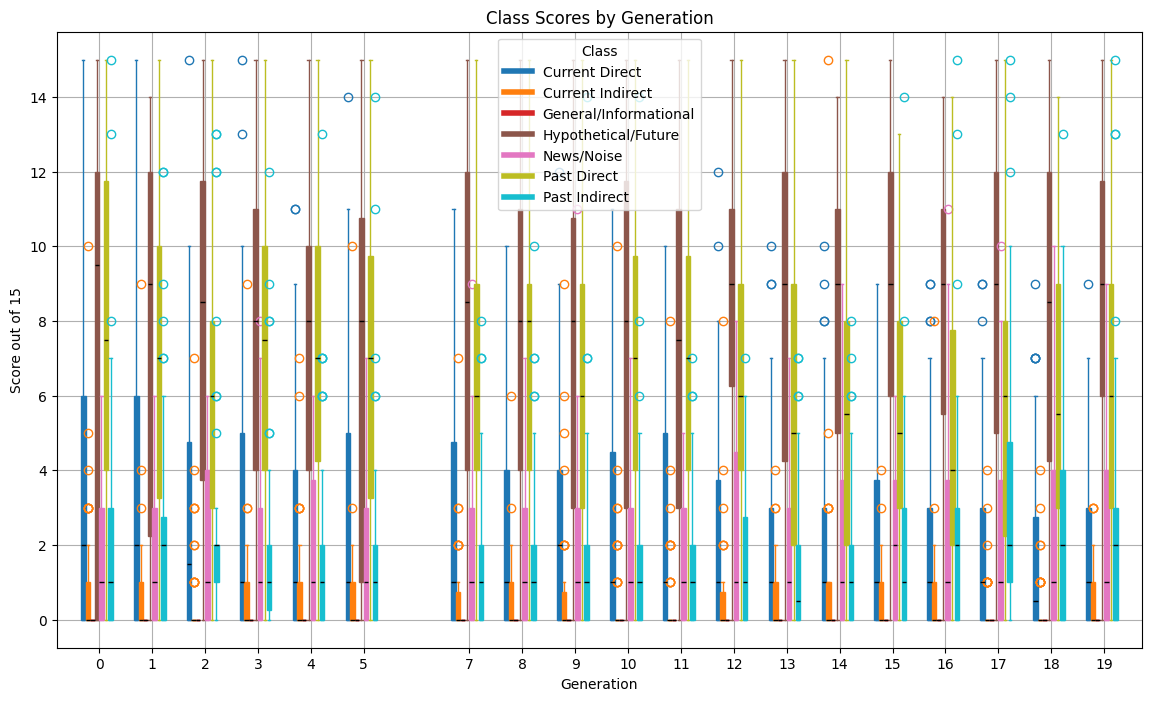

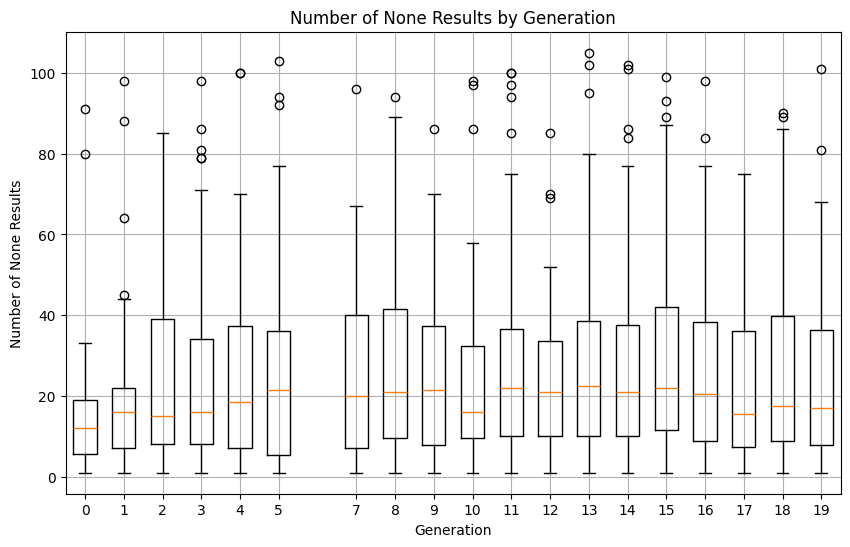

In [12]:
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_results_by_generation(answer_tracker):
    generation_data = defaultdict(list)
    
    # Group data by generation
    for generation, item_index, result, answer in answer_tracker:
        generation_data[generation].append((item_index, result, answer))
    
    generation_accuracies = {}
    generation_none_counts = defaultdict(int)
    
    # Calculate accuracy and None counts for each generation
    for generation, data in generation_data.items():
        total_items = len(data)
        correct_items = 0
        
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        for _, result, answer in data:
            class_total[answer] += 1
            if result == answer:
                correct_items += 1
                class_correct[answer] += 1
            if result is None:
                generation_none_counts[generation] += 1
        
        overall_score = correct_items  # Out of 15
        class_scores = {cls: class_correct[cls] for cls in class_total}
        
        generation_accuracies[generation] = (overall_score, class_scores)
    
    return generation_accuracies, generation_none_counts

def aggregate_accuracies(members):
    aggregated_overall_scores = defaultdict(list)
    aggregated_class_scores = defaultdict(lambda: defaultdict(list))
    aggregated_none_counts = defaultdict(list)
    
    for member in members:
        generation_accuracies, generation_none_counts = analyze_results_by_generation(member.answer_tracker)
        
        for generation, (overall_score, class_scores) in generation_accuracies.items():
            aggregated_overall_scores[generation].append(overall_score)
            for cls, score in class_scores.items():
                aggregated_class_scores[generation][cls].append(score)
        for generation, none_count in generation_none_counts.items():
            aggregated_none_counts[generation].append(none_count)
    
    return aggregated_overall_scores, aggregated_class_scores, aggregated_none_counts

# Get aggregated accuracies
aggregated_overall_scores, aggregated_class_scores, aggregated_none_counts = aggregate_accuracies(pop.members)

# Prepare data for plotting
generations = sorted(aggregated_overall_scores.keys())
class_labels = sorted(aggregated_class_scores[generations[0]].keys())
colors = plt.cm.get_cmap('tab10', len(class_labels))

# Box and whisker plot for overall score
# plt.figure(figsize=(10, 6))
# overall_data = [aggregated_overall_scores[g] for g in generations]
# plt.boxplot(overall_data, positions=generations, widths=0.6)
# plt.xlabel('Generation')
# plt.ylabel('Score out of 15')
# plt.title('Overall Score by Generation')
# plt.grid(True)
# plt.show()

# Box and whisker plots for class scores side by side
plt.figure(figsize=(14, 8))

box_width = 0.6 / len(class_labels)  # Adjust width to fit all boxes side by side
for i, cls in enumerate(class_labels):
    class_data = [aggregated_class_scores[g][cls] for g in generations]
    positions = [gen + (i - len(class_labels)/2) * box_width for gen in generations]
    plt.boxplot(class_data, positions=positions, widths=box_width, patch_artist=True,
                boxprops=dict(facecolor=colors(i), color=colors(i)),
                medianprops=dict(color='black'),
                whiskerprops=dict(color=colors(i)),
                capprops=dict(color=colors(i)),
                flierprops=dict(markeredgecolor=colors(i)))

# Adjust x-ticks to show only one tick per generation
plt.xticks(ticks=generations, labels=generations)

# Create legend
handles = [plt.Line2D([0], [0], color=colors(i), lw=4) for i in range(len(class_labels))]
plt.legend(handles, class_labels, title='Class')

plt.xlabel('Generation')
plt.ylabel('Score out of 15')
plt.title('Class Scores by Generation')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('class_scores_by_generation.png', bbox_inches='tight')

# Show the plot
plt.show()

# # Plot number of None results per prompt, per generation
# plt.figure(figsize=(10, 6))
# none_data = [aggregated_none_counts[g] for g in generations]
# plt.boxplot(none_data, positions=generations, widths=0.6)
# plt.xlabel('Generation')
# plt.ylabel('Number of None Results')
# plt.title('Number of None Results by Generation')
# plt.grid(True)

# # Save the plot as a PNG file
# plt.savefig('none_results_by_generation.png', bbox_inches='tight')

# # Show the plot
# plt.show()


Overall Accuracy Ignoring None Results: 25.53%


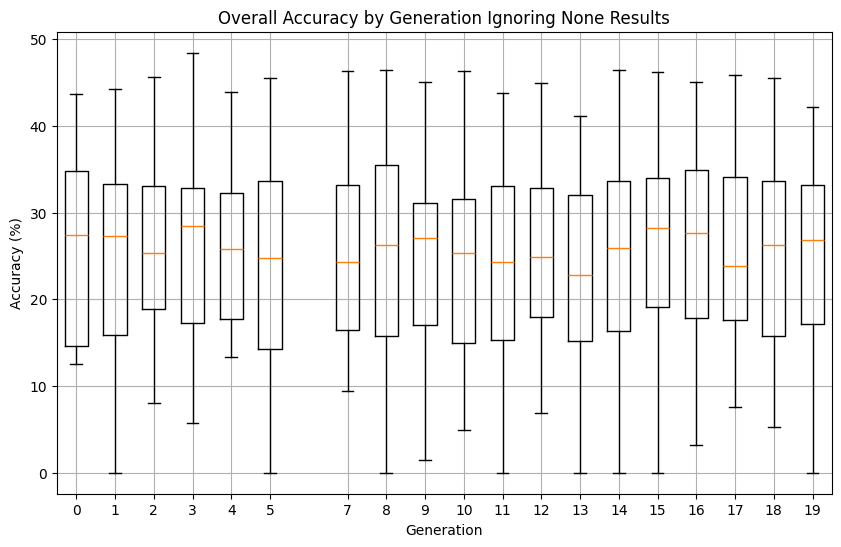

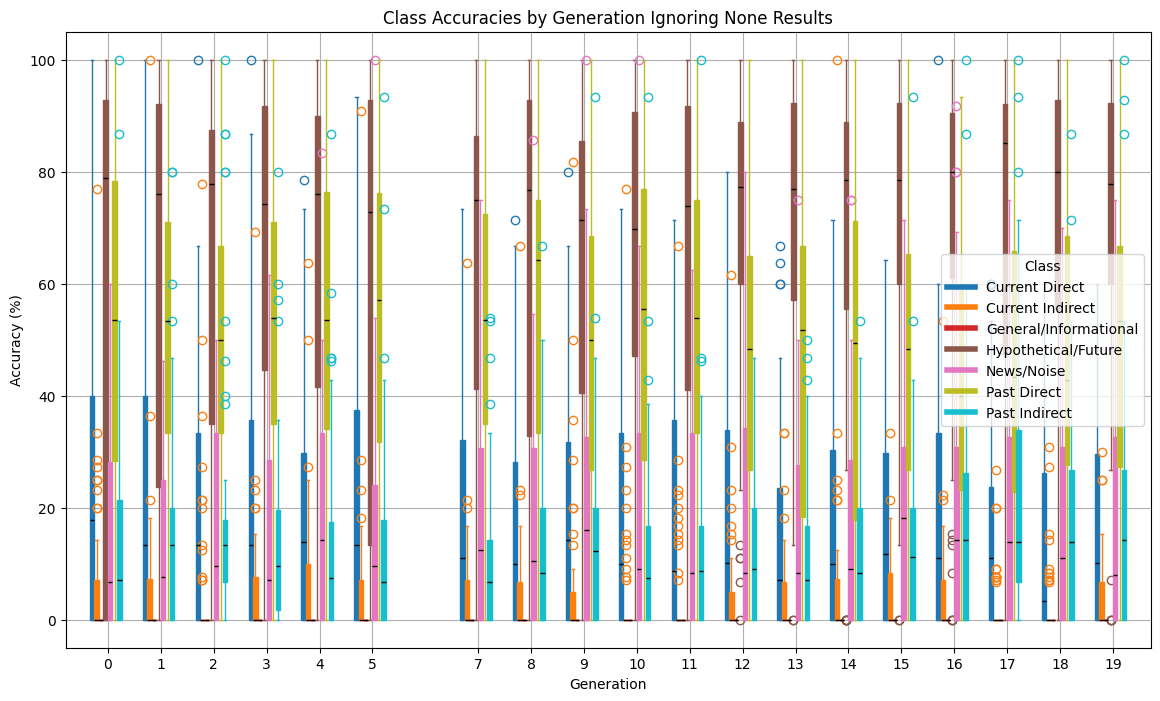

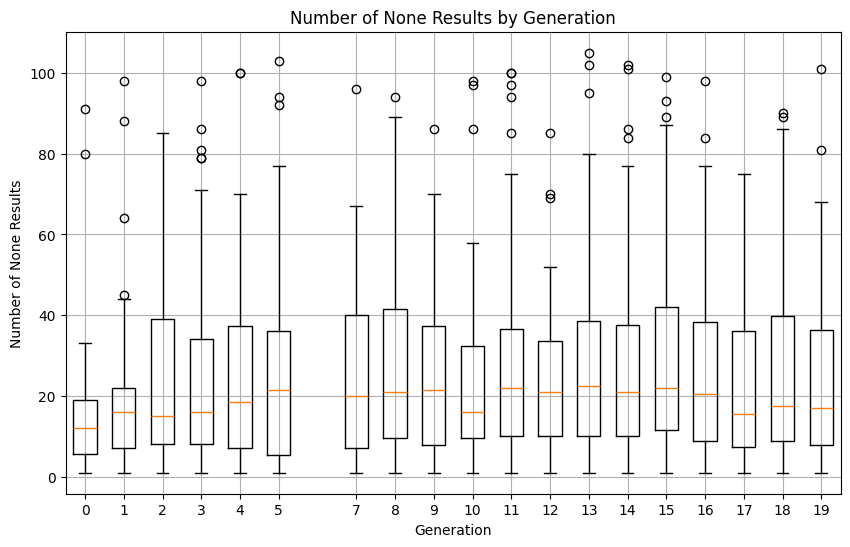

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt

def analyze_results_by_generation_no_nones(answer_tracker):
    generation_data = defaultdict(list)
    
    # Group data by generation
    for generation, item_index, result, answer in answer_tracker:
        generation_data[generation].append((item_index, result, answer))
    
    generation_accuracies = {}
    generation_none_counts = defaultdict(int)
    
    # Calculate accuracy and None counts for each generation
    for generation, data in generation_data.items():
        total_items = len(data)
        correct_items = 0
        valid_items = 0
        
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        class_none_counts = defaultdict(int)
        
        for _, result, answer in data:
            if result is not None:
                valid_items += 1
                class_total[answer] += 1
                if result == answer:
                    correct_items += 1
                    class_correct[answer] += 1
            else:
                generation_none_counts[generation] += 1
                class_none_counts[answer] += 1
        
        overall_accuracy = (correct_items / valid_items * 100) if valid_items > 0 else 0
        class_accuracies = {cls: (class_correct[cls] / class_total[cls] * 100) if class_total[cls] != 0 else 0 for cls in class_total}
        
        generation_accuracies[generation] = (overall_accuracy, class_accuracies, class_none_counts)
    
    return generation_accuracies, generation_none_counts

def aggregate_accuracies(members):
    aggregated_overall_accuracies = defaultdict(list)
    aggregated_class_accuracies = defaultdict(lambda: defaultdict(list))
    aggregated_none_counts = defaultdict(list)
    
    for member in members:
        generation_accuracies, generation_none_counts = analyze_results_by_generation_no_nones(member.answer_tracker)
        
        for generation, (overall_accuracy, class_accuracies, class_none_counts) in generation_accuracies.items():
            aggregated_overall_accuracies[generation].append(overall_accuracy)
            for cls, accuracy in class_accuracies.items():
                aggregated_class_accuracies[generation][cls].append(accuracy)
        for generation, none_count in generation_none_counts.items():
            aggregated_none_counts[generation].append(none_count)
    
    return aggregated_overall_accuracies, aggregated_class_accuracies, aggregated_none_counts

# Example usage
aggregated_overall_accuracies, aggregated_class_accuracies, aggregated_none_counts = aggregate_accuracies(pop.members)

# Calculate and print overall accuracy ignoring None results
all_overall_accuracies = [acc for acc_list in aggregated_overall_accuracies.values() for acc in acc_list]
overall_accuracy_ignoring_none = sum(all_overall_accuracies) / len(all_overall_accuracies) if all_overall_accuracies else 0
print(f"Overall Accuracy Ignoring None Results: {overall_accuracy_ignoring_none:.2f}%")

# Plotting as before...

# Box and whisker plot for overall accuracy
plt.figure(figsize=(10, 6))
overall_data = [aggregated_overall_accuracies[g] for g in generations]
plt.boxplot(overall_data, positions=generations, widths=0.6)
plt.xlabel('Generation')
plt.ylabel('Accuracy (%)')
plt.title('Overall Accuracy by Generation Ignoring None Results')
plt.grid(True)
plt.show()

# Box and whisker plots for class accuracies side by side
plt.figure(figsize=(14, 8))

box_width = 0.6 / len(class_labels)  # Adjust width to fit all boxes side by side
for i, cls in enumerate(class_labels):
    class_data = [aggregated_class_accuracies[g][cls] for g in generations]
    positions = [gen + (i - len(class_labels)/2) * box_width for gen in generations]
    plt.boxplot(class_data, positions=positions, widths=box_width, patch_artist=True,
                boxprops=dict(facecolor=colors(i), color=colors(i)),
                medianprops=dict(color='black'),
                whiskerprops=dict(color=colors(i)),
                capprops=dict(color=colors(i)),
                flierprops=dict(markeredgecolor=colors(i)))

# Adjust x-ticks to show only one tick per generation
plt.xticks(ticks=generations, labels=generations)

# Create legend
handles = [plt.Line2D([0], [0], color=colors(i), lw=4) for i in range(len(class_labels))]
plt.legend(handles, class_labels, title='Class')

plt.xlabel('Generation')
plt.ylabel('Accuracy (%)')
plt.title('Class Accuracies by Generation Ignoring None Results')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('class_accuracies_by_generation_ignoring_none.png', bbox_inches='tight')

# Show the plot
plt.show()

# Plot number of None results per prompt, per generation
plt.figure(figsize=(10, 6))
none_data = [aggregated_none_counts[g] for g in generations]
plt.boxplot(none_data, positions=generations, widths=0.6)
plt.xlabel('Generation')
plt.ylabel('Number of None Results')
plt.title('Number of None Results by Generation')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('none_results_by_generation.png', bbox_inches='tight')

# Show the plot
plt.show()


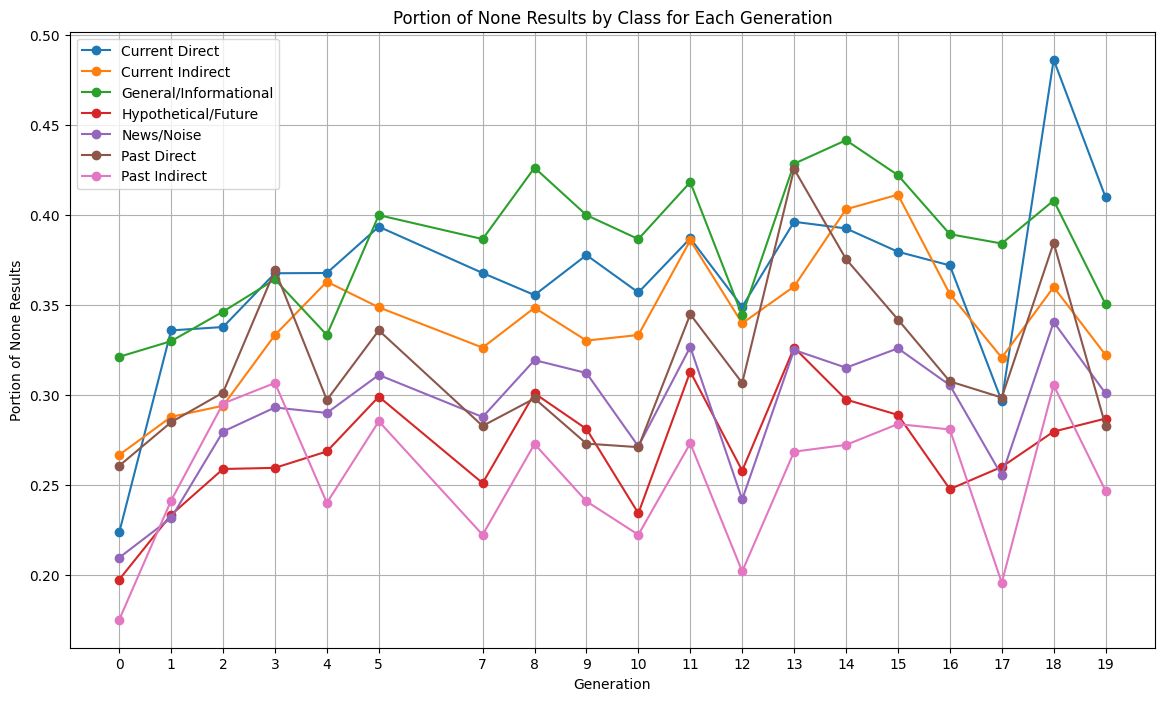

In [17]:
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_results_by_generation(answer_tracker):
    generation_data = defaultdict(list)
    
    # Group data by generation
    for generation, item_index, result, answer in answer_tracker:
        generation_data[generation].append((item_index, result, answer))
    
    generation_accuracies = {}
    generation_none_counts = defaultdict(int)
    generation_class_none_counts = defaultdict(lambda: defaultdict(int))
    generation_class_totals = defaultdict(lambda: defaultdict(int))
    
    # Calculate accuracy and None counts for each generation
    for generation, data in generation_data.items():
        total_items = len(data)
        correct_items = 0
        valid_items = 0
        
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        for _, result, answer in data:
            class_total[answer] += 1
            generation_class_totals[generation][answer] += 1
            if result is not None:
                valid_items += 1
                if result == answer:
                    correct_items += 1
                    class_correct[answer] += 1
            else:
                generation_none_counts[generation] += 1
                generation_class_none_counts[generation][answer] += 1
        
        overall_accuracy = (correct_items / valid_items * 100) if valid_items > 0 else 0
        class_accuracies = {cls: (class_correct[cls] / class_total[cls] * 100) if class_total[cls] != 0 else 0 for cls in class_total}
        
        generation_accuracies[generation] = (overall_accuracy, class_accuracies, generation_class_none_counts[generation])
    
    return generation_accuracies, generation_none_counts, generation_class_none_counts, generation_class_totals

def aggregate_accuracies(members):
    aggregated_overall_accuracies = defaultdict(list)
    aggregated_class_accuracies = defaultdict(lambda: defaultdict(list))
    aggregated_none_counts = defaultdict(list)
    aggregated_class_none_counts = defaultdict(lambda: defaultdict(list))
    aggregated_class_totals = defaultdict(lambda: defaultdict(list))
    
    for member in members:
        generation_accuracies, generation_none_counts, generation_class_none_counts, generation_class_totals = analyze_results_by_generation(member.answer_tracker)
        
        for generation, (overall_accuracy, class_accuracies, class_none_counts) in generation_accuracies.items():
            aggregated_overall_accuracies[generation].append(overall_accuracy)
            for cls, accuracy in class_accuracies.items():
                aggregated_class_accuracies[generation][cls].append(accuracy)
            for cls, none_count in class_none_counts.items():
                aggregated_class_none_counts[generation][cls].append(none_count)
        for generation, none_count in generation_none_counts.items():
            aggregated_none_counts[generation].append(none_count)
        for generation, class_totals in generation_class_totals.items():
            for cls, total in class_totals.items():
                aggregated_class_totals[generation][cls].append(total)
    
    return aggregated_overall_accuracies, aggregated_class_accuracies, aggregated_none_counts, aggregated_class_none_counts, aggregated_class_totals

# Example usage
aggregated_overall_accuracies, aggregated_class_accuracies, aggregated_none_counts, aggregated_class_none_counts, aggregated_class_totals = aggregate_accuracies(pop.members)

# Calculate None answer portion by class for each generation
class_none_portions = defaultdict(lambda: defaultdict(list))

for generation in aggregated_class_none_counts.keys():
    for cls in aggregated_class_none_counts[generation].keys():
        none_counts = aggregated_class_none_counts[generation][cls]
        totals = aggregated_class_totals[generation][cls]
        portions = [nc / t if t > 0 else 0 for nc, t in zip(none_counts, totals)]
        class_none_portions[generation][cls] = portions

# Plot portion of None results by class for each generation
plt.figure(figsize=(14, 8))

for cls in class_labels:
    portions_by_generation = [np.mean(class_none_portions[g][cls]) for g in generations]
    plt.plot(generations, portions_by_generation, marker='o', label=f'{cls}')
plt.xticks(ticks=generations, labels=generations)
plt.xlabel('Generation')
plt.ylabel('Portion of None Results')
plt.title('Portion of None Results by Class for Each Generation')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('none_portion_by_class_generation.png', bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_1800764/2986163115.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_labels))


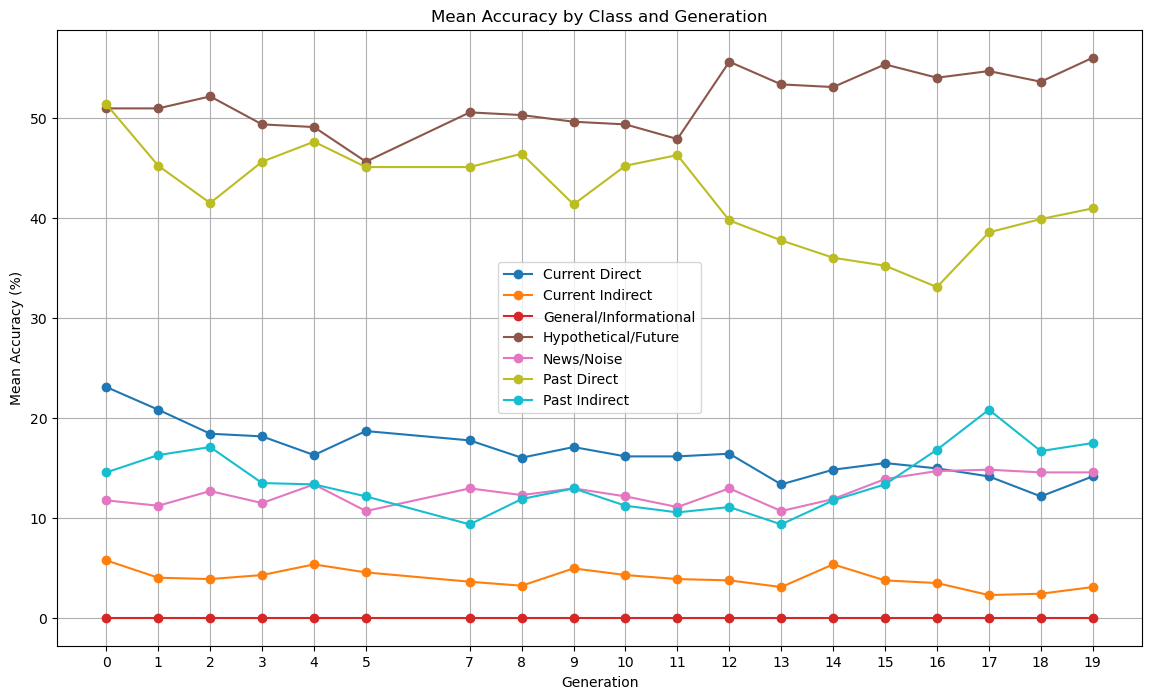

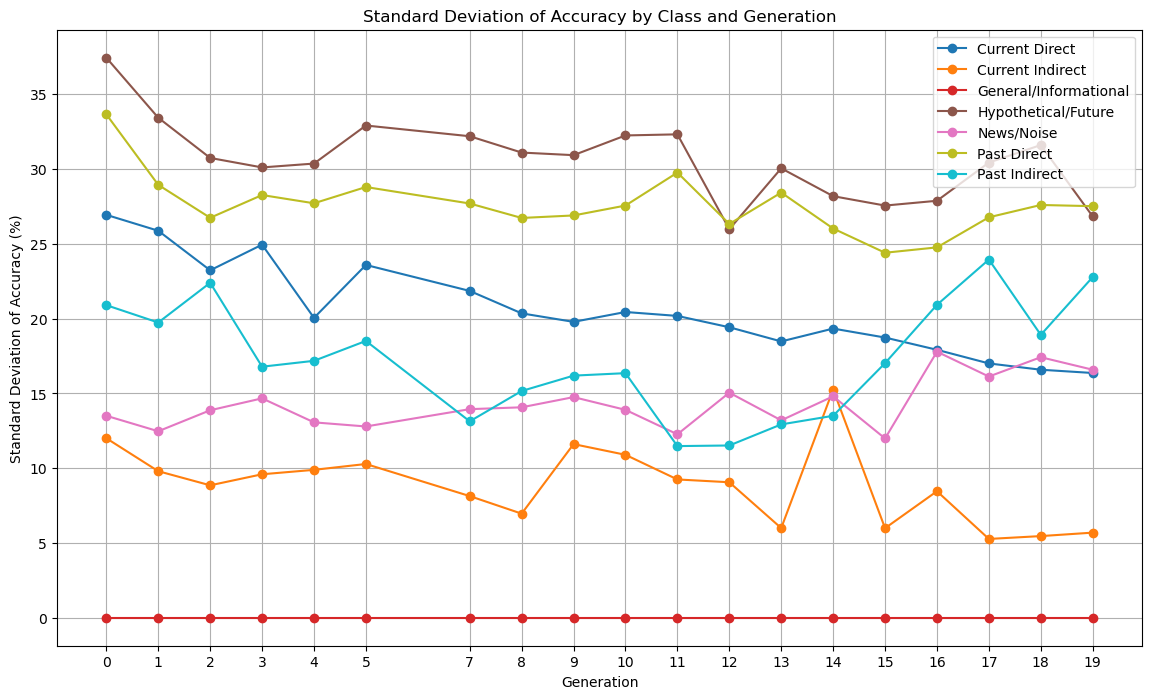

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def analyze_results_by_generation(answer_tracker):
    generation_data = defaultdict(list)
    
    # Group data by generation
    for generation, item_index, result, answer in answer_tracker:
        generation_data[generation].append((item_index, result, answer))
    
    generation_accuracies = {}
    
    # Calculate accuracy for each generation
    for generation, data in generation_data.items():
        total_items = len(data)
        correct_items = 0
        
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        for _, result, answer in data:
            class_total[answer] += 1
            if result == answer:
                correct_items += 1
                class_correct[answer] += 1
        
        overall_accuracy = correct_items / total_items * 100
        class_accuracies = {cls: (class_correct[cls] / class_total[cls] * 100) if class_total[cls] != 0 else 0 for cls in class_total}
        
        generation_accuracies[generation] = (overall_accuracy, class_accuracies)
    
    return generation_accuracies

def aggregate_accuracies(members):
    aggregated_overall_accuracies = defaultdict(list)
    aggregated_class_accuracies = defaultdict(lambda: defaultdict(list))
    
    for member in members:
        generation_accuracies = analyze_results_by_generation(member.answer_tracker)
        
        for generation, (overall_accuracy, class_accuracies) in generation_accuracies.items():
            aggregated_overall_accuracies[generation].append(overall_accuracy)
            for cls, acc in class_accuracies.items():
                aggregated_class_accuracies[generation][cls].append(acc)
    
    return aggregated_overall_accuracies, aggregated_class_accuracies

# Get aggregated accuracies
aggregated_overall_accuracies, aggregated_class_accuracies = aggregate_accuracies(pop.members)

# Prepare data for plotting
generations = sorted(aggregated_overall_accuracies.keys())
class_labels = sorted(aggregated_class_accuracies[generations[0]].keys())
colors = plt.cm.get_cmap('tab10', len(class_labels))

# Calculate mean and standard deviation
mean_accuracies = {cls: [np.mean(aggregated_class_accuracies[g][cls]) for g in generations] for cls in class_labels}
std_accuracies = {cls: [np.std(aggregated_class_accuracies[g][cls]) for g in generations] for cls in class_labels}

# Plot mean accuracy
plt.figure(figsize=(14, 8))
for i, cls in enumerate(class_labels):
    plt.plot(generations, mean_accuracies[cls], marker='o', color=colors(i), label=f'{cls}')

plt.xlabel('Generation')
plt.ylabel('Mean Accuracy (%)')
plt.title('Mean Accuracy by Class and Generation')
plt.legend()
plt.grid(True)
plt.xticks(ticks=generations, labels=[int(gen) for gen in generations])
plt.show()

# Plot standard deviation of accuracy
plt.figure(figsize=(14, 8))
for i, cls in enumerate(class_labels):
    plt.plot(generations, std_accuracies[cls], marker='o', color=colors(i), label=f'{cls}')

plt.xlabel('Generation')
plt.ylabel('Standard Deviation of Accuracy (%)')
plt.title('Standard Deviation of Accuracy by Class and Generation')
plt.legend()
plt.grid(True)
plt.xticks(ticks=generations, labels=[int(gen) for gen in generations])
plt.savefig('Standard Deviation of Accuracy by class and generation.png', bbox_inches='tight')
plt.show()


In [14]:
aggregated_overall_accuracies

defaultdict(list,
            {0: [29.523809523809526,
              12.380952380952381,
              2.857142857142857,
              42.857142857142854,
              30.476190476190478,
              28.57142857142857,
              14.285714285714285,
              14.285714285714285,
              14.285714285714285,
              9.523809523809524,
              30.476190476190478,
              33.33333333333333,
              38.095238095238095,
              14.285714285714285,
              20.0,
              27.61904761904762,
              34.285714285714285,
              24.761904761904763,
              14.285714285714285,
              25.71428571428571,
              20.952380952380953,
              26.666666666666668,
              26.666666666666668,
              14.285714285714285,
              32.38095238095238,
              25.71428571428571,
              13.333333333333334,
              20.0,
              32.38095238095238,
              32.3809523809523

In [69]:
len(my_object.members)

50

In [4]:
#best prompts
for i in my_object.best_members:
    print(i[0], i[1])
    print('---'*30)

0 ["  Unravel the intricate tapestry of perspectives, as diverse as the hues of an artist's palette, painting a vivid picture of living kidney donation experiences. Can you discern whether the Redditor's tale is one of the past, present, or yet to unfold, woven with threads of direct or indirect connection? Or perhaps it's a canvas of general knowledge, or simply background noise in the vast realm of online chatter."]
------------------------------------------------------------------------------------------
1 [" Ask a language model to categorize this Reddit user's experience of living kidney donation into one of these options: Current Direct, Current Indirect, Past Direct, Past Indirect, Hypothetical/Future, General/Informational, or News/Noise."]
------------------------------------------------------------------------------------------
2 [" Ask a language model to categorize this Reddit user's experience of living kidney donation into one of these options: Current Direct, Current Ind

In [20]:
#best accuracy
my_object.global_best_score

[37]

In [18]:
len(dfrs), len(acc)

(21, 22)

In [39]:
all_scores = []
for a,b in enumerate(acc):
    for j in b:
        all_scores.append((a,j))

all_scores

[14,
 14,
 15,
 13,
 14,
 8,
 17,
 15,
 12,
 4,
 5,
 9,
 10,
 10,
 7,
 4,
 9,
 5,
 11,
 17,
 18,
 22,
 22,
 26,
 21,
 28,
 25,
 25,
 27,
 25,
 25,
 20,
 25,
 26,
 24,
 25,
 22,
 24,
 24,
 24,
 21,
 21,
 15,
 2,
 18,
 18,
 8,
 5,
 5,
 7,
 4,
 14,
 12,
 13,
 1,
 14,
 14,
 17,
 14,
 27,
 27,
 26,
 27,
 21,
 20,
 23,
 25,
 23,
 24,
 20,
 17,
 7,
 2,
 22,
 24,
 20,
 15,
 14,
 13,
 8,
 3,
 14,
 14,
 14,
 13,
 14,
 3,
 0,
 1,
 2,
 6,
 5,
 11,
 13,
 15,
 12,
 13,
 11,
 10,
 17,
 18,
 21,
 26,
 25,
 23,
 7,
 9,
 11,
 15,
 16,
 13,
 22,
 19,
 16,
 18,
 21,
 18,
 18,
 18,
 19,
 20,
 22,
 4,
 0,
 10,
 13,
 18,
 25,
 22,
 21,
 18,
 19,
 18,
 17,
 19,
 19,
 23,
 17,
 16,
 18,
 22,
 17,
 5,
 4,
 10,
 10,
 5,
 23,
 3,
 8,
 7,
 17,
 3,
 7,
 8,
 6,
 22,
 17,
 13,
 15,
 15,
 4,
 19,
 16,
 15,
 16,
 10,
 2,
 13,
 19,
 2,
 7,
 9,
 13,
 5,
 11,
 13,
 14,
 15,
 13,
 17,
 17,
 15,
 16,
 15,
 18,
 17,
 22,
 22,
 13,
 13,
 11,
 11,
 19,
 21,
 18,
 7,
 5,
 4,
 7,
 13,
 12,
 13,
 9,
 1,
 1,
 3,
 11,
 10,
 25,
 24

In [36]:
#get the initial prompts
len(dfrs[0])

19

In [32]:
#accuracy over time
acc = []
dfrs = []
count = 0
for i in pop.members:
    acc.append(i.accuracy_history)
    dfrs.append(i.avg_distance_history)
    count+=1

In [127]:
for i in my_object.members:
    print(i.avg_distance_history)

[0.98, 0.6949794, 0.68989754, 0.725853, 0.7036244, 0.7167736, 0.71864885, 0.76060265, 0.7720269, 0.76697516, 0.72604907, 0.7219285, 0.7188836, 0.71711314, 0.7555972, 0.74814284, 0.74741226, 0.75443876, 0.73104864, 0.7891143]
[0.98, 0.74136984, 0.7377819, 0.88915914, 0.9016746, 0.90298384, 0.789869, 0.80167997, 0.8143065, 0.8204599, 0.7707991, 0.75569624, 0.75081426, 0.7532722, 0.76879585, 0.7621699, 0.80961794, 0.77017105, 0.76583093, 0.7891143]
[0.98, 0.70804703, 0.7028552, 0.7053781, 0.6984166, 0.7137971, 0.71603316, 0.7263714, 0.79752374, 0.79667753, 0.79878855, 0.7925748, 0.79045033, 0.78892034, 0.78894234, 0.795523, 0.7981306, 0.79221594, 0.74749786, 0.7891143]
[0.98, 0.6949499, 0.6940434, 0.70346606, 0.68976235, 0.70166236, 0.7119347, 0.71964705, 0.728221, 0.7293988, 0.726539, 0.72156656, 0.72021645, 0.71757346, 0.7250789, 0.7226696, 0.72407293, 0.72064555, 0.72434103, 0.7891143]
[0.98, 0.6839256, 0.6842689, 0.69284105, 0.7142048, 0.7214518, 0.7649038, 0.8042358, 0.8183534, 0.800

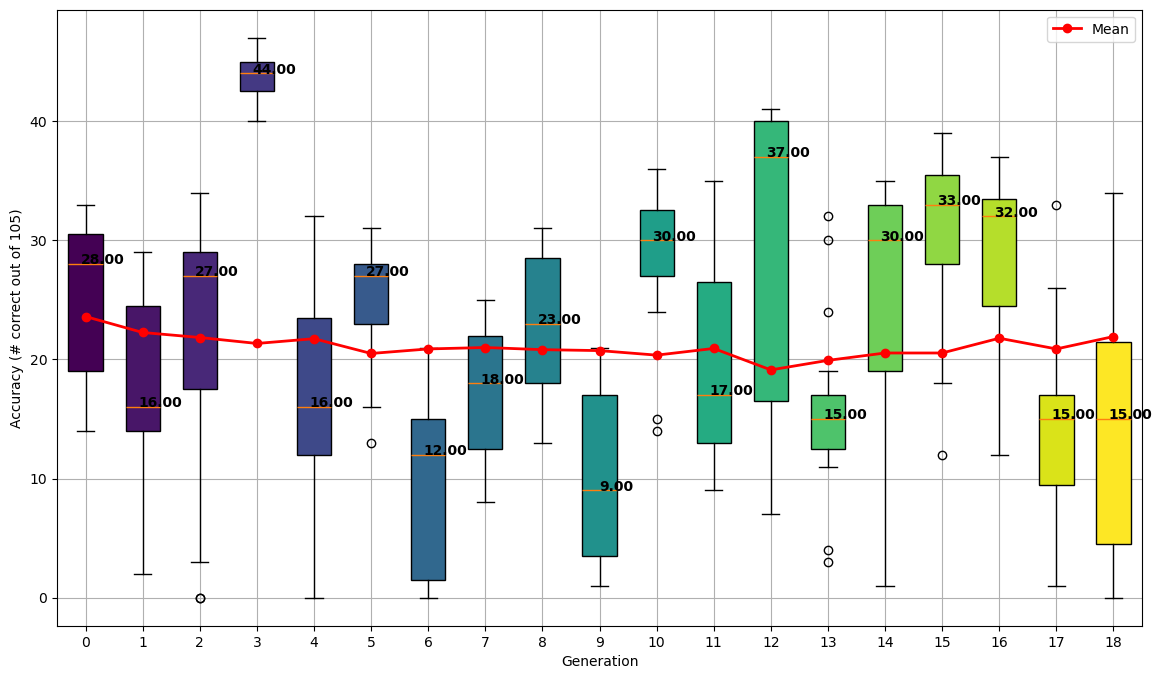

In [50]:
# Creating a box plot for the provided data with enhanced visualization (without mean labels)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(14, 8))

# Plotting the box plot with patch_artist for color
box = plt.boxplot([acc[i] for i in range(len(acc[0]))], positions=range(len(acc[0])), widths=0.6, patch_artist=True)

# Adding a consistent color scheme
colors = plt.cm.viridis(np.linspace(0, 1, len(acc[0])))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Adding annotations for median
for i, line in enumerate(box['medians']):
    x, y = line.get_xydata()[1]  # Median point
    plt.text(x, y, f'{y:.2f}', horizontalalignment='center', color='black', weight='bold')

# Calculate and plot mean values without labels
means = [np.mean([acc[j][i] for j in range(len(acc))]) for i in range(len(acc[0]))]
plt.plot(range(len(acc[0])), means, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')

# Enhancing plot details
# plt.title('Box Plot of Genetic Algorithm Generations')
plt.xlabel('Generation')
plt.ylabel('Accuracy (# correct out of 105)')
plt.legend()
plt.grid(True)
plt.show()


In [107]:
my_object.get_DFR()

/home/jeniel01/anaconda3/lib/python3.11/site-packages/matplotlib/lines.py:1205: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


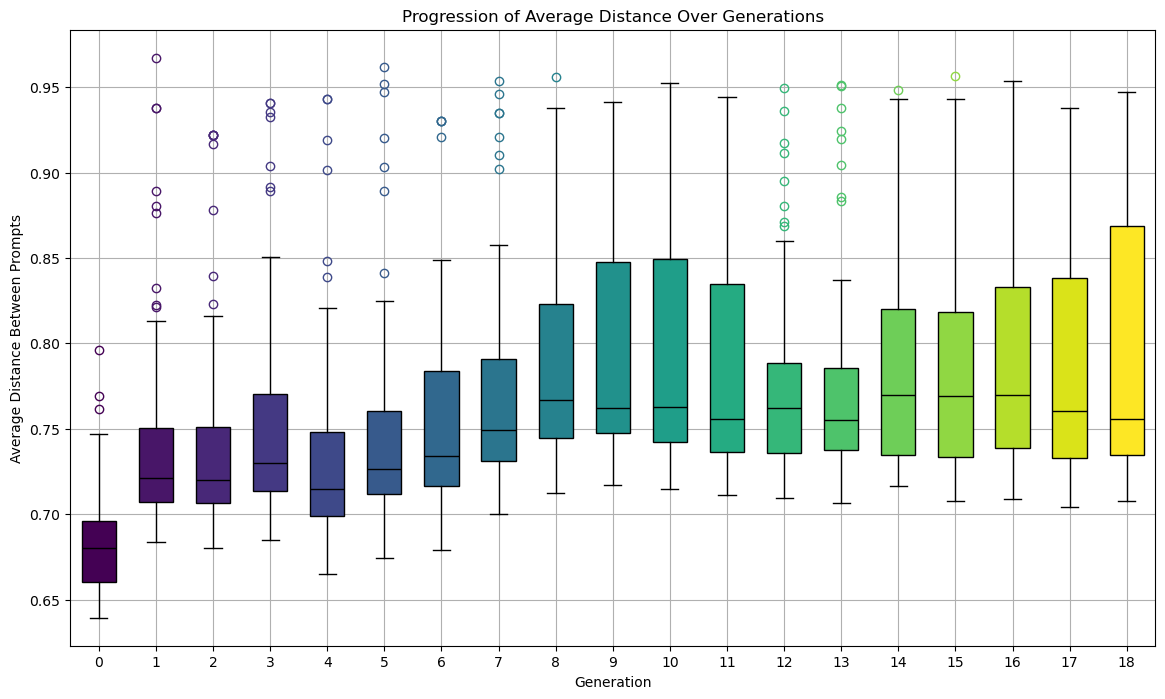

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `dfrs` is the given list of 50 lists, where each internal list contains 20 DFR values (one for each generation).

# Prepare data for plotting
num_generations = len(dfrs[0])
num_individuals = len(dfrs)

# Transpose the DFRs list to group values by generation
dfrs_by_generation = [[dfrs[individual][generation] for individual in range(num_individuals)] for generation in range(num_generations)]
# print(dfrs_by_generation)
# Create the box and whisker plot with colors
plt.figure(figsize=(14, 8))
box = plt.boxplot(dfrs_by_generation, positions=range(num_generations), widths=0.6, patch_artist=True)

# Apply colors
colors = plt.cm.viridis(np.linspace(0, 1, num_generations))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize other box plot elements to match the colors
for whisker, color in zip(box['whiskers'], np.repeat(colors, 2)):
    if isinstance(color, np.float64):
        color = '0'
    whisker.set_color(color)
for cap, color in zip(box['caps'], np.repeat(colors, 2)):
    if isinstance(color, np.float64):
        color = '0'
    cap.set_color(color)
for median, color in zip(box['medians'], colors):
    if isinstance(color, np.float64):
        color = '0'
    median.set_color('black')
for flier, color in zip(box['fliers'], colors):
    if isinstance(color, np.float64):
        color = '0'
    flier.set(markeredgecolor=color)

plt.xlabel('Generation')
plt.ylabel('Average Distance Between Prompts')
plt.title('Progression of Average Distance Over Generations')
plt.grid(True)

# Adjust x-ticks to show only integers
plt.xticks(ticks=range(num_generations), labels=[int(gen) for gen in range(num_generations)])
# plt.savefig('Avg_dist_over_generations.png')
plt.show()


In [1]:
for i,j in pop.promptimal_frontier_history:
    print(j)
   # for k in j:
   #     print(i, k.prompt)
   #     print('---'*30)

NameError: name 'pop' is not defined

In [74]:
pop.promptimal_frontier_history[1]

(1, [<__main__.Member at 0x7faf20db8cd0>])

In [85]:
for i in range(19):
    if len(pop.promptimal_frontier_history[i][1])>1:
        sentences_gen = [member.prompt for member in pop.promptimal_frontier_history[i][1]]
    
        # Encode all sentences
        embeddings = model.encode(sentences_gen)
        
        # Compute cosine similarity between all pairs
        cos_sim = util.cos_sim(embeddings, embeddings)
        dm = 1 - cos_sim
        normalized_distance = ((dm.numpy() if hasattr(dm, 'numpy') else dm) + 1) / 2
        np.fill_diagonal(normalized_distance, 0)  # Now this should work
        print(normalized_distance)
        print('---'*20)

[[0.         0.62650645 0.5932256 ]
 [0.62650645 0.         0.63399094]
 [0.5932256  0.63399094 0.        ]]
------------------------------------------------------------
[[0.        0.5932256]
 [0.5932256 0.       ]]
------------------------------------------------------------
[[0.         0.62650645]
 [0.62650645 0.        ]]
------------------------------------------------------------
[[0.         0.62650645 0.73041713]
 [0.62650645 0.         0.7355269 ]
 [0.73041713 0.7355269  0.        ]]
------------------------------------------------------------
[[0.         0.73041713 0.5932256 ]
 [0.73041713 0.         0.7104296 ]
 [0.5932256  0.7104296  0.        ]]
------------------------------------------------------------
[[0.         0.5932256  0.715938  ]
 [0.5932256  0.         0.71433556]
 [0.715938   0.71433556 0.        ]]
------------------------------------------------------------
[[0.       0.715938]
 [0.715938 0.      ]]
---------------------------------------------------------

In [42]:
#final promptimal frontier
for i in my_object.promptimal_frontier:
    print(i.score, i.prompt, i.DFR)
    print('---'*30)

42  -----------------------------------------------------                                              Before diving into analyzing the user's account, take a moment to clear your mind and approach the text with a fresh perspective. Now, carefully examine the flow of information provided by the Reddit user about their experience with living kidney donation. Determine if their account is an informative piece, a personal experience, or simply noise in the conversation. Identify whether the experience is current or past, direct (donating their own kidney) or indirect (someone close donating their kidney), hypothetical, or general information. 0.4352170524895191
------------------------------------------------------------------------------------------
39  For this prompt, I would create a mutated version by focusing on the unique aspects of the Reddit platform and how users share personal experiences. I would design a bot that can analyze Reddit comments and posts for keywords and phrases 

In [53]:
#evaluate the number of times a prompt returned a none answer
theNones = []
for i, j in enumerate(pop.members):
    none_counter = 0
    for k in j.answer_tracker:
        if k[2]==None:
            none_counter += 1
            

[(0, 0, None, 'News/Noise'), (0, 1, None, 'General/Informational'), (0, 2, 'News/Noise', 'News/Noise'), (0, 3, 'Current Direct', 'General/Informational'), (0, 4, 'Current Direct', 'Past Direct'), (0, 5, 'News/Noise', 'News/Noise'), (0, 6, 'Hypothetical/Future', 'News/Noise'), (0, 7, 'Hypothetical/Future', 'Hypothetical/Future'), (0, 8, None, 'General/Informational'), (0, 9, 'Past Direct', 'Past Direct'), (0, 10, 'Current Direct', 'Current Direct'), (0, 11, 'News/Noise', 'General/Informational'), (0, 12, 'Hypothetical/Future', 'Current Indirect'), (0, 13, 'Past Indirect', 'General/Informational'), (0, 14, 'Hypothetical/Future', 'Current Indirect'), (0, 15, 'Current Indirect', 'Current Direct'), (0, 16, None, 'Current Indirect'), (0, 17, 'Past Direct', 'Past Direct'), (0, 18, 'Hypothetical/Future', 'Hypothetical/Future'), (0, 19, 'Current Direct', 'Current Direct'), (0, 20, None, 'Current Indirect'), (0, 21, 'Hypothetical/Future', 'Current Direct'), (0, 22, 'Hypothetical/Future', 'News/N

Top 10 prompts with the highest number of None results:
Prompt 84: 560 None results
Prompt 29: 520 None results
Prompt 26: 514 None results
Prompt 39: 493 None results
Prompt 38: 490 None results
Prompt 51: 482 None results
Prompt 90: 482 None results
Prompt 67: 446 None results
Prompt 71: 438 None results
Prompt 69: 420 None results

Details of top prompts with highest None results:

Prompt 84 (None results: 560):
 The final prompt is shown below in bold text.                                                                                **Describe your experience with living kidney donation, being sure to mention whether it is direct or indirect, current or past, or if it is hypothetical, general, news, or noise.**

Prompt 29 (None results: 520):
 The final prompt is shown below in bold text.                                                                                **Describe your experience with living kidney donation, being sure to mention whether it is direct or indirect, cur

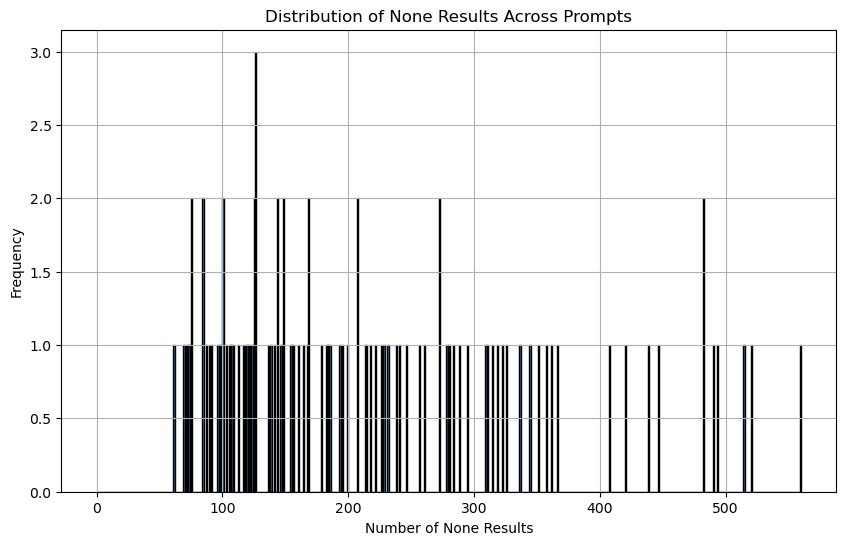

In [64]:
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_none_results_by_prompt(answer_tracker):
    prompt_none_counts = defaultdict(int)
    
    # Count None results for each prompt
    for generation, item_index, result, answer in answer_tracker:
        if result is None:
            prompt_none_counts[item_index] += 1
    
    return prompt_none_counts

def aggregate_none_results(members):
    aggregated_none_counts = defaultdict(int)
    
    for member in members:
        prompt_none_counts = analyze_none_results_by_prompt(member.answer_tracker)
        
        for prompt, count in prompt_none_counts.items():
            aggregated_none_counts[prompt] += count
    
    return aggregated_none_counts

# Get aggregated None results
aggregated_none_counts = aggregate_none_results(pop.members)

# Sort prompts by the number of None results
sorted_none_counts = sorted(aggregated_none_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top prompts with the highest number of None results
top_n = 10  # Change this to display more or fewer prompts
print(f"Top {top_n} prompts with the highest number of None results:")
for prompt, count in sorted_none_counts[:top_n]:
    print(f"Prompt {prompt}: {count} None results")

# Retrieve and analyze the content of the top prompts
def retrieve_prompt_content(members, prompt_index):
    for member in members:
        for generation, item_index, result, answer in member.answer_tracker:
            if item_index == prompt_index:
                return member.prompt_history[generation]
    return None

print("\nDetails of top prompts with highest None results:")
for prompt_index, count in sorted_none_counts[:top_n]:
    prompt_content = retrieve_prompt_content(pop.members, prompt_index)
    print(f"\nPrompt {prompt_index} (None results: {count}):\n{prompt_content}")

# Optional: Save detailed analysis to a file
with open('top_none_prompts_analysis.txt', 'w') as file:
    for prompt_index, count in sorted_none_counts[:top_n]:
        prompt_content = retrieve_prompt_content(pop.members, prompt_index)
        file.write(f"\nPrompt {prompt_index} (None results: {count}):\n{prompt_content}\n")

# Analyze distribution of None results
none_counts = [count for _, count in sorted_none_counts]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(none_counts, bins=range(0, max(none_counts)+1, 1), edgecolor='black')
plt.xlabel('Number of None Results')
plt.ylabel('Frequency')
plt.title('Distribution of None Results Across Prompts')
plt.grid(True)
plt.show()


In [10]:
#get a table of generations (rows) and prompts (columns)
all_prompts = []
for i in pop.members:
    all_prompts.append(i.prompt_history)
all_prompts = pd.DataFrame(all_prompts)
df = all_prompts.transpose()
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,The final prompt is shown below in bold text....,What type of experience with living kidney do...,A mutated prompt that encourages the user to ...,---------------------------------------------...,A new prompt with an emphasis on finding spec...,If you want to be the best in the world at id...,Use the below Reddit post as your source mate...,The type of experience with living kidney don...,The type of experience with living kidney don...,The user mentions that they have never seen a...,...,What is the type of experience with living ki...,"""Consider a time when you had to identify som...",Instead of regularly u...,Past Direct\n\nThe user's description of meet...,1) You should look for whether the user is de...,The user's experience is Past Direct Living K...,Identify the type of experience with living k...,The user is describing a Past Direct experien...,The user's experience seems to be 'Past Direc...,Provide advice on how to identify the type of...
1,The user mentions being evaluated for living k...,None,None,None,To understand the Reddit user's experience wi...,None,'Using the below Reddit post as your source m...,"\n\nOh, hark! A tale of donating kidneys fair,...",User is referring to themselves in first person,"""Imagine you're an ali...",...,The user describes a current direct experienc...,A Reddit-style question asking if the user ha...,Before making a decisi...,Have you ever donated a kidney to someone in ...,None,"Sure, I can help you with that! The instructi...",Imagine you are an ali...,The user is envisioning a Future Direct expe...,None,"The mutator prompt is as follows: ""Imagine yo..."
2,"Sure, I can descri...",[Past Direct],The user is describing their Past Indirect ex...,None,"Prompt: ""My friend just received a kidney tra...",News/Noise,What is your opinion on living kidney donatio...,None,*Describe your experience with living kidney d...,"\n\n""Consider yourself a sentient algorithm ta...",...,"""Past Direct - Positive Emotion"".\n\nInput:\n...",Have you or someone you know ever been involv...,Prompt: “You shared your experience about liv...,\n\nHave you ever considered donating a kidney...,Determine the type of experience with living ...,How would you explain ...,None,\n\nWhat was the most meaningful moment you ex...,Past Direct,Revised Prompt:\nYour task is to imagine bein...
3,None,None,A rhyme scheme prompt that asks for the user ...,None,"To ensure your understanding, can you summa...",The type of personal experience with living k...,The output should be a single reddit comment ...,None,Use a template and some code logic in your pr...,\n\n{\n'type': 'General/Informational'\n},...,The speaker feels gratified and joyful reflec...,Write a fantasy story about a wizard who uses...,None,None,"A rhyming quatrain, where each quatrain descr...",A rhythmic verse that inspires creativity and...,The user is describing a hypothetical or futu...,Post/comment text to analyze and solution ...,Prompt: In-depth analysis of the user’s uniqu...,Past Direct: A user who has donated their kid...
4,Living kidney don...,\n\nA rhythmic verse that celebrates the tran...,\n\ndef get\_personal\_experience\_with\_livin...,None,The process of donating a kidney to a friend ...,\n\nPrompt: What kind of personal experience ...,"""I'm thinking about becoming a living kidney d...",The user states they are a current indirect li...,"\n\nHi there,\n\nWe've detected a Reddit post ...","\n\n{\n'type': 'Past Direct',\n'confidence': 0...",...,None,"In the absurd, upside-down world of Catopia, ...",None,None,TYPE EXPERIENCE\n\nPAST INDIRECT\n\nExplanati...,Original Reddit post: “I just got accepted as...,To effectively recognize the sort of individu...,The user shared a heartwarming story about th...,"""\n\nTake a moment to clear your mind. Now, c...",The next prompt should be:\n\nImagine you are...
5,Describe your experience with living kidney d...,"Mutated Prompt 1: ""Imagine walking a tig

In [9]:
def fill_none_with_above(df):
    while df.isnull().any().any():
        df = df.fillna(method='ffill')
    return df

# Replace all 'None' with actual None type for the operation
# df = df.applymap(lambda x: None if x == 'None' else x)

# Fill None values
df_filled = fill_none_with_above(df)

# Display the result
df_filled

/tmp/ipykernel_1810650/2288504842.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,The final prompt is shown below in bold text....,What type of experience with living kidney do...,A mutated prompt that encourages the user to ...,---------------------------------------------...,A new prompt with an emphasis on finding spec...,If you want to be the best in the world at id...,Use the below Reddit post as your source mate...,The type of experience with living kidney don...,The type of experience with living kidney don...,The user mentions that they have never seen a...,...,What is the type of experience with living ki...,"""Consider a time when you had to identify som...",Instead of regularly u...,Past Direct\n\nThe user's description of meet...,1) You should look for whether the user is de...,The user's experience is Past Direct Living K...,Identify the type of experience with living k...,The user is describing a Past Direct experien...,The user's experience seems to be 'Past Direc...,Provide advice on how to identify the type of...
1,The user mentions being evaluated for living k...,What type of experience with living kidney do...,A mutated prompt that encourages the user to ...,---------------------------------------------...,To understand the Reddit user's experience wi...,If you want to be the best in the world at id...,'Using the below Reddit post as your source m...,"\n\nOh, hark! A tale of donating kidneys fair,...",User is referring to themselves in first person,"""Imagine you're an ali...",...,The user describes a current direct experienc...,A Reddit-style question asking if the user ha...,Before making a decisi...,Have you ever donated a kidney to someone in ...,1) You should look for whether the user is de...,"Sure, I can help you with that! The instructi...",Imagine you are an ali...,The user is envisioning a Future Direct expe...,The user's experience seems to be 'Past Direc...,"The mutator prompt is as follows: ""Imagine yo..."
2,"Sure, I can descri...",[Past Direct],The user is describing their Past Indirect ex...,---------------------------------------------...,"Prompt: ""My friend just received a kidney tra...",News/Noise,What is your opinion on living kidney donatio...,"\n\nOh, hark! A tale of donating kidneys fair,...",*Describe your experience with living kidney d...,"\n\n""Consider yourself a sentient algorithm ta...",...,"""Past Direct - Positive Emotion"".\n\nInput:\n...",Have you or someone you know ever been involv...,Prompt: “You shared your experience about liv...,\n\nHave you ever considered donating a kidney...,Determine the type of experience with living ...,How would you explain ...,Imagine you are an ali...,\n\nWhat was the most meaningful moment you ex...,Past Direct,Revised Prompt:\nYour task is to imagine bein...
3,"Sure, I can descri...",[Past Direct],A rhyme scheme prompt that asks for the user ...,---------------------------------------------...,"To ensure your understanding, can you summa...",The type of personal experience with living k...,The output should be a single reddit comment ...,"\n\nOh, hark! A tale of donating kidneys fair,...",Use a template and some code logic in your pr...,\n\n{\n'type': 'General/Informational'\n},...,The speaker feels gratified and joyful reflec...,Write a fantasy story about a wizard who uses...,Prompt: “You shared your experience about liv...,\n\nHave you ever considered donating a kidney...,"A rhyming quatrain, where each quatrain descr...",A rhythmic verse that inspires creativity and...,The user is describing a hypothetical or futu...,Post/comment text to analyze and solution ...,Prompt: In-depth analysis of the user’s uniqu...,Past Direct: A user who has donated their kid...
4,Living kidney don...,\n\nA rhythmic verse that celebrates the tran...,\n\ndef get\_personal\_experience\_with\_livin...,---------------------------------------------...,The process of donating a kidney to a friend ...,\n\nPrompt: What kind of personal experience ...,"""I'm thinking about becoming a living

In [ ]:
def frontier(population_generation):
    # First, calculate or update the distance matrix for the current population
    model = SentenceTransformer("all-MiniLM-L6-v2").to('cpu')
    sentences = [a.prompt for a in self.members]
    
    # Encode all sentences
    embeddings = model.encode(sentences)
    
    # Compute cosine similarity between all pairs
    cos_sim = util.cos_sim(embeddings, embeddings)
    self.distance_matrix = 1 - cos_sim
    
    current_max_score = max(member.score for member in self.members)
    frontier_max_score = max((member.score for member in self.promptimal_frontier), default=0)  # default=0 handles empty frontier
    max_score = max(current_max_score, frontier_max_score)
    min_score = max_score * (1 - self.accuracy_threshold)

    # Filter out members that do not meet the score criteria
    self.promptimal_frontier = [member for member in self.promptimal_frontier if member.score >= min_score]

    # Identify new candidates to add to the frontier, excluding those already in it
    new_candidates = [member for member in self.members if member.score >= min_score and member not in self.promptimal_frontier]

    for new_member in new_candidates:
        member_index = self.members.index(new_member)

        eligible_for_frontier = True  # Assume eligibility until proven otherwise

        for frontier_member in self.promptimal_frontier:
            frontier_member_index = self.members.index(frontier_member)

            # Check if new member is too similar to any in the frontier
            if self.distance_matrix[member_index, frontier_member_index] < (1 - self.similarity_limit):
                eligible_for_frontier = False
                break

        if eligible_for_frontier:
            self.promptimal_frontier.append(new_member)
    self.promptimal_frontier_history.append((self.generation, self.promptimal_frontier))

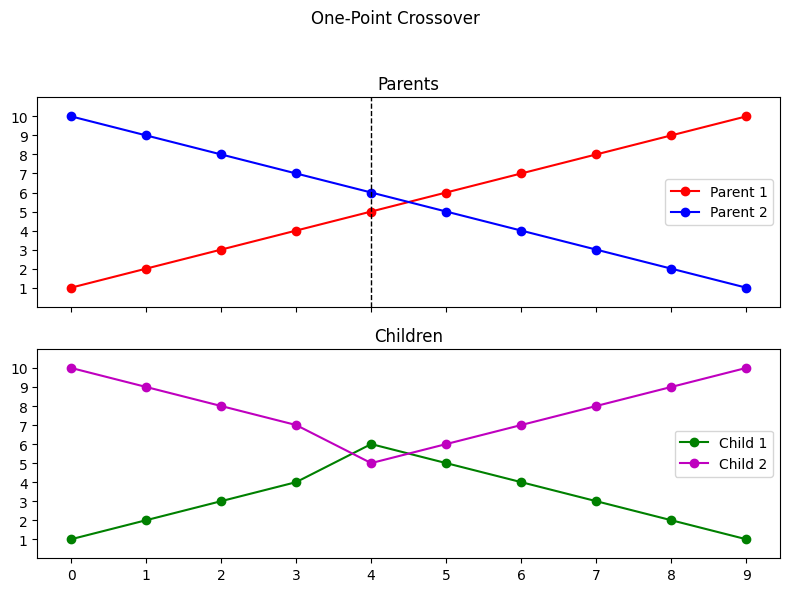

In [23]:
import matplotlib.pyplot as plt

def plot_crossover(parent1, parent2, child1, child2, crossover_points, title):
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # Increased vertical size
    
    for ax in axs:
        ax.set_yticks(range(1, 11))  # Assuming values range from 1 to 10
        ax.set_xticks(range(len(parent1)))  # Assuming chromosome length
        ax.set_ylim(0, 11)  # Adjusting y-axis limits to fit all values
    
    # Plotting parents in the first subplot
    axs[0].plot(parent1, 'ro-', label='Parent 1')
    axs[0].plot(parent2, 'bo-', label='Parent 2')
    axs[0].set_title('Parents')
    for point in crossover_points:
        axs[0].axvline(point, color='k', linestyle='--', lw=1)
    axs[0].legend()
    
    # Plotting children in the second subplot
    axs[1].plot(child1, 'go-', label='Child 1')
    axs[1].plot(child2, 'mo-', label='Child 2')
    axs[1].set_title('Children')
    axs[1].legend()
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# One-Point Crossover Example
parent1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
parent2 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

crossover_point = 4
child1_one_point = parent1[:crossover_point] + parent2[crossover_point:]
child2_one_point = parent2[:crossover_point] + parent1[crossover_point:]

plot_crossover(parent1, parent2, child1_one_point, child2_one_point, [crossover_point], 'One-Point Crossover')

# Two-Point Crossover Example
point1, point2 = 3, 7
# child1_two_point = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
# child2_two_point = parent2[:point1] + parent1[point1:point2] + parent2[point2:]

# plot_crossover(parent1, parent2, child1_two_point, child2_two_point, [point1, point2], 'Two-Point Crossover')
